# Get to Know a Dataset: DE Africa Sentinel 5P TROPOMI Level-2

This notebook serves as a guided tour of the [Digital Earth Africa Sentinel-5P TROPOMI Level-2](https://registry.opendata.aws/[REGISTRY_YAML_NAME]) dataset. More usage examples, tutorials, and documentation for this dataset and others can be found at the [Registry of Open Data on AWS](https://registry.opendata.aws/).



### Dataset Organization & S3 Prefix Structure Overview
***

At the top level of our S3 buckets, we follow a **consistent, product-centric prefix structure** that supports scalable, cloud-native access to **Sentinel-5P TROPOMI Level-2 products stored as Cloud-Optimised GeoTIFFs (COGs)**.

##### Dataset organisation and key S3 prefix structure
1. **Top-level S3 bucket (per product)**

   Each atmospheric variable is stored in its own dedicated S3 bucket, for example:

   * `deafrica-sentinel-5p-aer-ai`
   * `deafrica-sentinel-5p-no2`
   * `deafrica-sentinel-5p-ch4`
   * `deafrica-sentinel-5p-so2`

   This separation simplifies data discovery, access management, and scaling as data volumes grow.

2. **Mission prefix**

   ```
   Sentinel-5p/
   ```

   Identifies the satellite mission and allows future missions to be added without restructuring existing paths.

3. **Instrument prefix**

   ```
   TROPOMI/
   ```

   Specifies the sensor producing the observations and keeps all Sentinel-5P products organised consistently.

4. **Processing level and product prefix**

   Each Level-2 product is stored in a dedicated directory, for example:

   * `TROPO_L2_AI` – Aerosol Index
   * `TROPO_L2_NO2` – Nitrogen Dioxide
   * `TROPO_L2_SO2` – Sulphur Dioxide
   * `TROPO_L2_CO` – Carbon Monoxide
   * `TROPO_L2_CH4` – Methane
   * `TROPO_L2_O3` – Ozone
   * `TROPO_L2_HCHO` – Formaldehyde
   * `TROPO_L2_CLOUD` – Cloud properties

   This ensures a clear one-to-one mapping between scientific products and directory paths.

5. **Temporal partitioning**

   Products are partitioned by time using:

   ```
   YYYY/MM/DD/
   ```

   or, where appropriate:

   ```
   YYYY/MM/
   ```

   Example:

   ```
   s3://deafrica-sentinel-5p-no2/Sentinel-5p/TROPOMI/TROPO_L2_NO2/2025/11/
   ```

   Temporal partitioning enables efficient S3 prefix filtering and time-based subsetting in cloud workflows.

6. **Cloud-Optimised GeoTIFFs (COGs)**

   Within each temporal directory are individual **Cloud-Optimised GeoTIFF (`.tif`) files**, where:

   * each file represents a single Sentinel-5P overpass or daily mosaic
   * internal tiling and overviews enable HTTP range requests
   * files can be streamed directly into GIS tools, xarray/rioxarray, and Dask without full downloads


Full documentation for this dataset can be found at: [https://docs.digitalearthafrica.org/en/latest/data_specs/Sentinel-5P_specs.html](https://docs.digitalearthafrica.org/en/latest/data_specs/Sentinel-5P_specs.html)




#### Install and import packages

Depending on your environment, you may need to install some packages before importing them. The installation commands in the cell below are effective in Sagemaker Studio Lab (with kernel set to `sagemaker-distribution:Python`) and Google Colab.

If you are running the notebook for the first time, you can remove the `#`s and run the cell below. Often it is more aesthetic to add the `#`s back in after the cell has run because the outputs take a lot of space!

You may see some dependency resolver errors in the output, though this should not affect performance and did not during testing in Colab and SageMaker.

In [1]:
# This notebook requires the following additional libraries
# (Please install using the preferred method for your environment by uncommenting the appropriate lines below):

# !pip install pystac==1.10.0 --force-reinstall
# !pip install odc-stac
# !pip install osmnx
# !pip install pystac_client
# !pip install odc-algo
# !pip install matplotlib

In [2]:
# Import the libraries required for this notebook
# Built-ins
import numpy as np
import xarray as xr
import pandas as pd

# Installed libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import odc.algo
from pystac_client import Client
from odc.stac import configure_rio, stac_load

### Data Formats, Content Types & Practical Usage Guidance

***

Our dataset is stored using **cloud-native geospatial formats**, chosen to support scalable access, analysis, and visualisation directly from S3 without full file downloads.

#### Data formats present in the dataset

##### 1. Cloud-Optimised GeoTIFF (COG) — `.tif`

**What is stored**

* Sentinel-5P TROPOMI **Level-2 atmospheric products** (e.g. CH₄, NO₂, SO₂, CO, O₃, Aerosol Index, Clouds)
* Each file represents a **single overpass or temporally aggregated product**
* Raster grids with georeferencing, metadata, and quality information

**Why this format is used**

* Internally tiled with overviews
* Supports HTTP range requests
* Optimised for direct cloud access from S3

**How we work with it**

* Stream directly from S3 using `rasterio`, `rioxarray`, or `xarray`
* Subset spatially and temporally without downloading full files
* Visualise instantly in GIS tools (QGIS, ArcGIS)

**Advice**

* Always treat these as *remote datasets*—avoid downloading unless necessary
* Use windowed reads and bounding boxes for performance
* Prefer `rioxarray.open_rasterio()` or STAC-based loading for analysis



##### 2. STAC metadata (JSON)

**What is stored**

* Collection-level and item-level metadata exposed via the **Digital Earth Africa STAC catalogue**
* Spatial extent, temporal coverage, projection, and asset links pointing to the COGs in S3

**Why this format is used**

* Enables structured discovery and filtering of large datasets
* Decouples metadata from physical storage layout

**How we work with it**

* Query using `pystac_client`
* Filter by bounding box, time range, and product type
* Use STAC assets to access COGs programmatically

**Advice**

* Use STAC as the *entry point* rather than hard-coding S3 paths
* Let STAC handle discovery; let raster tools handle reading

This approach keeps workflows **fast, scalable, and cloud-efficient**, even when working with large time series of Sentinel-5P atmospheric products.

----

### Downloading and Loading Data from the Dataset

We define the location of our dataset, configure access to AWS S3, and prepare the environment for cloud-native data access

We start by configuring Rasterio/GDAL for unsigned (public) S3 access and explicitly point to the Africa (Cape Town) AWS region, where the data are hosted.
This configuration ensures that Cloud-Optimised GeoTIFFs can be accessed efficiently via HTTP range requests without downloading entire files.

In [3]:
configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

Next, we open the Digital Earth Africa STAC catalogue, which provides a structured index over the underlying S3 buckets.
We then define:
1. spatial bounding box (in latitude/longitude),
2. temporal window, and
3. the Sentinel-5P TROPOMI Level-2 CH₄ collection to query:

In [4]:
# Open the stac catalogue
catalog = Client.open("https://explorer.digitalearth.africa/stac")

# Set a bounding box
# [xmin, ymin, xmax, ymax] in latitude and longitude
bbox = [ 28.3, -26.6,  30.3, -24.6]

# Set a start and end date
start_date = '2023-07-18' 
end_date = '2023-07-19'

To load other Sentinel-5P TROPOMI Level-2 products, the user only needs to change the value inside the collections list. Each product is exposed as a separate STAC collection 

The available options are:
 - `s5p_tropomi_l2_ai` to work with the Aerosol Index product.
 - `s5p_tropomi_l2_no2` to load Nitrogen Dioxide (NO₂) data.
 - `s5p_tropomi_l2_so2` to access Sulphur Dioxide (SO₂) observations.
 - `s5p_tropomi_l2_co` to analyse Carbon Monoxide (CO) concentrations.
 - `s5p_tropomi_l2_o3` to work with Ozone (O₃) data.
 - `s5p_tropomi_l2_hcho` to load Formaldehyde (HCHO) products.
 - `s5p_tropomi_l2_ch4` to analyse Methane (CH₄) concentrations.
 - `s5p_tropomi_l2_cloud` to access Cloud properties derived from TROPOMI.
   
If a user wishes to load other Sentinel-5P TROPOMI Level-2 products, they simply need to replace `s5p_tropomi_l2_co` in the collections list with the collection corresponding to their variable of interest.

In [5]:
# Set the STAC collections
collections = ["s5p_tropomi_l2_co"]

The code block below builds and executes a STAC search query using the parameters you defined earlier, then reports how many matching datasets were found.

First, a query is constructed against the Digital Earth Africa STAC catalogue using:
 - the spatial extent (bbox)
 - the selected Sentinel-5P collection(s) (collections)
 - the time range (start_date to end_date)

In [6]:
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

Next, the query is executed and all matching STAC items (each representing an individual dataset, typically a single overpass or time slice) are retrieved:

In [7]:
# Search the STAC catalog for all items matching the query
items = list(query.items())

Finally, the total number of datasets returned by the search is printed:

In [8]:
print(f"Found: {len(items):d} datasets")

Found: 22 datasets


#### Loads the STAC items into an Xarray Dataset

This step **loads the STAC items into an Xarray Dataset** using cloud-native access, converting the Sentinel-5P STAC assets into an analysis-ready data cube.

Here is what each parameter in `stac_load` is doing:

##### Explanation of key parameters

* **`items`**
  The list of STAC items returned from the catalogue search. Each item corresponds to a Sentinel-5P TROPOMI observation.

* **`crs="EPSG:4326"`**
  Reprojects the data to geographic coordinates (latitude/longitude), making it easy to work with vector boundaries and other global datasets.

* **`chunks={}`**
  Loads the data lazily (Dask-ready) without forcing a specific chunk size. This is appropriate for small time ranges or exploratory analysis.

* **`groupby="solar_day"`**
  Groups individual overpasses by **solar day**, which is particularly important for Sentinel-5P since multiple orbits can occur within a single day.

* **`bbox=bbox`**
  Spatially subsets the data to the defined area of interest, reducing data volume and improving performance.

* **`resolution=-0.01`**
  Sets the output spatial resolution (~1 km at the equator). The negative value ensures correct north-up orientation.

In [9]:
ds_co = stac_load(
    items,
    crs='EPSG:4326',
    chunks={},
    groupby="solar_day",
    bbox=bbox,
    resolution = -0.01,
)

#### Resulting dataset

The output, `ds_co`, is an **Xarray Dataset** that:

* contains gridded Sentinel-5P Carbon Monoxide (CO) data
* is spatially and temporally subsetted
* is ready for time-series analysis, mapping, or aggregation
* streams data directly from Cloud-Optimised GeoTIFFs in S3

Displaying `ds_co` in the notebook allows you to inspect:

* available variables
* spatial dimensions (`x`, `y`)
* temporal dimension (`time` or `solar_day`)
* metadata and coordinate information

This dataset can now be used for visualisation, statistics, or further cloud-scale processing.

In [10]:
# View the Xarray Dataset
ds_co

<xarray.Dataset> Size: 643kB
Dimensions:      (latitude: 200, longitude: 200, time: 2)
Coordinates:
  * latitude     (latitude) float64 2kB -26.6 -26.59 -26.58 ... -24.62 -24.61
  * longitude    (longitude) float64 2kB 30.3 30.29 30.28 ... 28.33 28.32 28.31
  * time         (time) datetime64[ns] 16B 2023-07-18 2023-07-19
    spatial_ref  int32 4B 4326
Data variables:
    CO           (time, latitude, longitude) float32 320kB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    dataMask     (time, latitude, longitude) float32 320kB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>

This line applies the quality mask to the dataset, ensuring that only valid Sentinel-5P observations are retained for analysis. This is a recommended best practice step before any aggregation, mapping, or interpretation of the products.

In [11]:
ds_co = ds_co.where(ds_co.dataMask == 1)

### Visual Insights from the Dataset

The plot below provides a **clear visual summary of what this dataset offers and why it is powerful**:

/opt/venv/lib/python3.12/site-packages/rasterio/warp.py:385: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


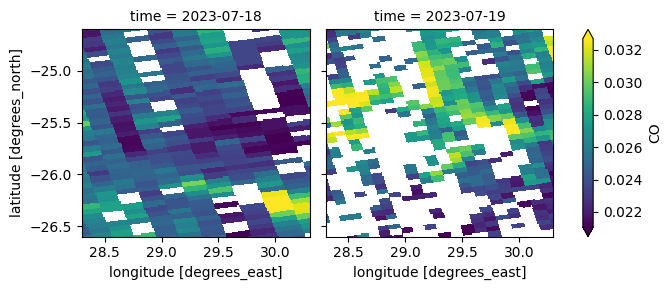

In [12]:
ds_co['CO'].plot(robust=True, col="time")

#### What this visual shows

* Each panel represents **Carbon Monoxide (CO) concentrations for a single solar day**, gridded over the area of interest.
* The use of `col="time"` creates a **small-multiples view**, making it easy to compare spatial patterns from day to day.


#### Why this is informative

* You can immediately see **hotspots and gradients** in methane concentrations across space.
* Day-to-day differences highlight **temporal variability**, which may be linked to:

  * emissions from agriculture, wetlands, or urban areas
  * atmospheric transport
  * changing observation conditions
* Masked (blank) areas clearly show where **quality filtering** has removed invalid pixels, reinforcing confidence in the data.

#### Why this should excite users

* This is **satellite methane data streamed directly from the cloud**, not pre-downloaded files.
* With just a few lines of code, users can:

  * visualise atmospheric composition over any region
  * build time series
  * compare multiple Sentinel-5P products (e.g. CH₄ vs NO₂ or CO)
* The same workflow scales seamlessly from **two days** to **multiple years** of observations.

#### Takeaway

This visual demonstrates that the dataset is:

* **analysis-ready**
* **spatially rich**
* **temporally dense**
* and perfectly suited for **exploratory science, policy analysis, and storytelling**

It invites users to dig deeper—whether to investigate emission sources, track changes over time, or combine methane with other atmospheric variables for a more complete picture of air quality and climate drivers.

### Calculating Total Atmospheric Gas Mass (Tonnes) from Sentinel-5P TROPOMI Data

Sentinel-5P TROPOMI Level-2 products provide atmospheric trace-gas measurements as **vertical column densities** in units of **mol/m² and Part Per Billions (PPB)**. These values represent the number of moles of a gas contained in an atmospheric column above each satellite pixel. 

#### Why Compute Tonnes?

Expressing gas amounts in tonnes provides a **policy-relevant and intuitive metric** for:

- Evaluating emission sources (urban, industrial, biomass burning, wetlands)
- Quantifying atmospheric loading during pollution episodes
- Comparing different gases on the same scale
- Reporting mass-based metrics for climate and air-quality frameworks
- Supporting SDG and AU Agenda 2063 environmental assessments

Converting trace-gas columns into physically meaningful mass values allows researchers and decision-makers to translate satellite observations into actionable insights.

---

#### Molecular Weights Used in the Conversion

The molecular weight determines how many grams one mole of a gas weighs:

| Gas | Molecular Weight (g/mol) |
|-----|---------------------------|
| CH₄ (Methane) | 16.04 |
| CO (Carbon Monoxide) | 28.01 |
| NO₂ (Nitrogen Dioxide) | 46.005 |
| SO₂ (Sulfur Dioxide) | 64.066 |
| HCHO (Formaldehyde) | 30.026 |
| O₃ (Ozone) | 48.00 |

These values are provided to the conversion function so that any Sentinel-5P gas product can be processed consistently.

---

The function below performs the full conversion from **Sentinel-5P TROPOMI Level-2 gas column data** (provided in **mol/m²**) into **total atmospheric mass expressed in tonnes** for your area of interest (AOI). 

To run the calculation, you only need to supply:

1. **The gas column variable** from your dataset  
   - Examples: `no2_tropospheric_column`, `co_column`, `so2_column`, `hcho_column`, `ozone_total_vertical_column`
   - `ch4_column` is in ppb, it must be converted to an appropriate column amount (e.g., mol/m²) before converting it to tonnes.

2. **The molecular weight of the gas** (in g/mol)  

The function automatically:
- Computes pixel areas from the latitude/longitude grid  
- Applies cloud masking if needed  
- Converts mol/m² → mol → grams → tonnes  
- Sums across all valid pixels  

This allows you to transform satellite-observed column densities into a meaningful physical metric (tonnes) for environmental analysis, climate studies, emission tracking, and reporting.



In [13]:
def compute_tonnes_timeseries(ds, molecular_weight):
    """
    Computes total atmospheric mass (tonnes) for every timestep in a Sentinel-5P
    Dataset or DataArray. Automatically detects the gas variable if needed.
    Returns a DataFrame with 'timestep' and 'tonnes' columns.
    """

    # -------------------------------------------------------
    # Case 1: Input is a DataArray
    # -------------------------------------------------------
    if isinstance(ds, xr.DataArray):
        gas_da_all = ds

    # -------------------------------------------------------
    # Case 2: Input is a Dataset
    # -------------------------------------------------------
    elif isinstance(ds, xr.Dataset):
        non_dimension_vars = [
            v for v in ds.data_vars
            if v not in ["latitude", "longitude", "time", "dataMask"]
        ]

        if len(non_dimension_vars) != 1:
            raise ValueError(f"Could not detect gas variable. Found: {non_dimension_vars}")

        gas_var = non_dimension_vars[0]
        gas_da_all = ds[gas_var]

    else:
        raise TypeError("Input must be an xarray Dataset or DataArray")

    R = 6371000  # Earth radius
    results = []

    # -------------------------------------------------------
    # Loop over timesteps
    # -------------------------------------------------------
    for idx, t in enumerate(gas_da_all.time.values):
        da = gas_da_all.isel(time=idx)

        # Apply dataMask if available
        if isinstance(ds, xr.Dataset) and "dataMask" in ds:
            da = da.where(ds["dataMask"].isel(time=idx) == 1)

        lat = da.latitude
        lon = da.longitude

        # Compute resolution
        dlat = np.abs(lat.diff("latitude").mean().item())
        dlon = np.abs(lon.diff("longitude").mean().item())

        # Convert to radians
        lat_rad = np.deg2rad(lat)
        dlat_rad = np.deg2rad(dlat)
        dlon_rad = np.deg2rad(dlon)

        # Pixel area (1-D latitude)
        area_1d = R**2 * np.cos(lat_rad) * dlat_rad * dlon_rad
        area_da = xr.DataArray(area_1d, coords={"latitude": lat}, dims=["latitude"])

        # Expand to full grid
        area_full = area_da.broadcast_like(da)

        # mol/m² → mol → grams → tonnes
        mol_per_pixel = da * area_full
        grams_per_pixel = mol_per_pixel * molecular_weight
        tonnes_per_pixel = grams_per_pixel / 1e6

        total_tonnes = tonnes_per_pixel.sum(skipna=True).item()

        results.append([pd.to_datetime(t), total_tonnes])

    # -------------------------------------------------------
    # Return a DataFrame with headers
    # -------------------------------------------------------
    df = pd.DataFrame(results, columns=["timestep", "tonnes"])
    df["tonnes"] = df["tonnes"].apply(lambda x: f"{x:,.0f}")
    return df

To convert the product to tonnes, we need the s5p_tropomi_l2_cloud dataset. In the next cell, the s5p_tropomi_l2_cloud product will be loaded to support this conversion.
The s5p_tropomi_l2_cloud product is needed because clouds block part of the atmospheric column. Without cloud filtering, trace-gas columns are incomplete, causing underestimation when converting concentrations to tonnes. Cloud data ensures only fully observed, physically meaningful columns are summed.

In [14]:
# Set the STAC collections
collections = ['s5p_tropomi_l2_cloud']

# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

ds_cloud = stac_load(
    items,
    crs='EPSG:4326',
    chunks={},
    groupby="solar_day",
    bbox=bbox,
    resolution = -0.01,
)

# View the Xarray Dataset
ds_cloud

Found: 22 datasets


<xarray.Dataset> Size: 2MB
Dimensions:                  (latitude: 200, longitude: 200, time: 2)
Coordinates:
  * latitude                 (latitude) float64 2kB -26.6 -26.59 ... -24.61
  * longitude                (longitude) float64 2kB 30.3 30.29 ... 28.32 28.31
  * time                     (time) datetime64[ns] 16B 2023-07-18 2023-07-19
    spatial_ref              int32 4B 4326
Data variables:
    dataMask                 (time, latitude, longitude) float32 320kB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    CLOUD_FRACTION           (time, latitude, longitude) float32 320kB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    CLOUD_TOP_HEIGHT         (time, latitude, longitude) float32 320kB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    CLOUD_BASE_HEIGHT        (time, latitude, longitude) float32 320kB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    CLOUD_TOP_PRESSURE       (time, latitude, longitude) float32 320kB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    CLOUD_BASE_PRESSURE      (time, latitude, longitude) float32 320kB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    CLOUD_OPTICAL_THICKNESS  (time, latitude, longitude) float32 320kB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>

In the cell below, we demonstrate how to compute the total atmospheric mass of Carbon Monoxide (CO) total column over the selected Area of Interest (AOI) using Sentinel-5P TROPOMI Level-2 data from the CO dataset already loaded above. The calculation applies the previously defined conversion function, which transforms to total mass (tonnes) by combining pixel area and molecular weight, with optional cloud masking. This workflow quantifies the total Carbon Monoxide present within the AOI, and the same approach can be applied to other Sentinel-5P trace-gas products by supplying the relevant gas variable and molecular weight. Note: Methane(CH4) is reported in ppb, an additional conversion step will be included to convert it to mol/m² before computing tonnes. The dataMask flags whether a pixel contains a valid gas retrieval, while the s5p_tropomi_l2_cloud product provides cloud information—specifically the cloud_fraction—which we use to exclude pixels where cloud contamination would reduce the accuracy of atmospheric gas measurements. A cloud threshold of 0.3 is recommended because it effectively removes pixels where cloud contamination begins to significantly degrade gas retrieval accuracy while still preserving enough clear-sky observations for reliable analysis.

In [15]:
cloud_mask = ds_cloud['CLOUD_FRACTION'] < 0.3

This line applies the cloud mask to the methane data, ensuring that only pixels with acceptable cloud conditions are retained. This step improves the physical reliability of any spatial summaries or mass calculations derived from the methane product.

In [16]:
mask_co = ds_co['CO'].where(cloud_mask)

#### Visualising the CH₄ Column After Removing Cloud-Contaminated Pixel

The plot below shows the CH₄ column values over the Area of Interest (AOI) after applying a cloud-fraction filter to remove pixels with excessive cloud contamination. Sentinel-5P methane retrievals can be strongly affected by cloud cover, so we retain only pixels where `cloud_fraction < 0.3`. This ensures that the visualisation reflects clearer and more reliable methane observations for the selected 2-day time period.

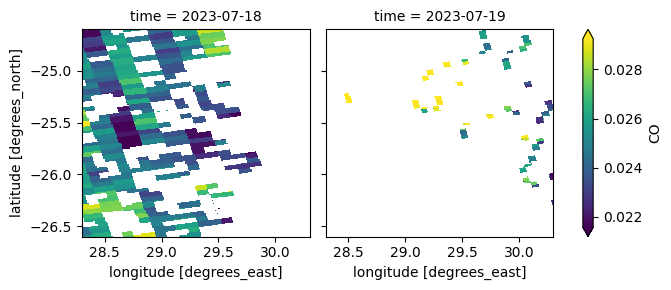

In [17]:
mask_co.plot(robust=True, col="time")

This step converts the cloud-screened methane data into a time series of total atmospheric mass (in tonnes) and displays the results in a dataframe format.

In [18]:
CO_tonnes_ts = compute_tonnes_timeseries(
    mask_co.compute(),
    molecular_weight=28.01,
)

CO_tonnes_ts

,timestep,tonnes
0,2023-07-18,"12,055"
1,2023-07-19,"1,017"


We queried Sentinel-5P TROPOMI CH₄ observations for a small area and short time window using the DE Africa STAC catalogue. The data were streamed as cloud-optimised GeoTIFFs into an Xarray Dataset, then filtered using the retrieval quality mask (`dataMask == 1`). To ensure physically meaningful mass estimates, we also loaded the Sentinel-5P cloud product and applied a cloud mask, retaining only pixels with low cloud cover. Finally, we converted the cloud-screened methane columns to total atmospheric mass (tonnes) and summarised the results as a time series.

The resulting time series reveals day-to-day variability in methane mass that is robust to cloud contamination. This approach demonstrates how Sentinel-5P data can be used not just for mapping concentrations, but for producing defensible, mass-based metrics that users can scale to longer periods, larger regions, or compare across multiple atmospheric gases.


### Limitations and next steps

Sentinel-5P TROPOMI provides near-daily, continental-scale coverage, making it possible to detect recurring spatial patterns and seasonal signals that are difficult to observe with sparse ground measurements.

* Analyse **multi-year time series** rather than short windows to separate seasonal cycles from noise.
* Apply **strict quality and cloud filtering** before any aggregation or tonne conversion.
* Use **consistent spatial grids and temporal grouping** (e.g. solar day or monthly composites).
* Combine CH₄ with other Sentinel-5P products (e.g. CO or NO₂) and land-use datasets to help infer potential emission sources.
* Validate patterns where possible using inventories or independent observations.

This approach allows users to move from short-term exploration to **robust, policy-relevant insights** on methane emissions and their drivers.
